<a href="https://colab.research.google.com/github/KM-Pusat/SkimLit_NLP/blob/main/NLP_SkimLit_Project_KMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Project : SkimLit 💻🔥

**SkimLit** adalah sebuah proyek yang berfokus pada penggunaan teknik Pemrosesan Bahasa Alami (**Natural Language Processing/NLP**) untuk mengekstrak informasi terstruktur dari literatur ilmiah, khususnya artikel penelitian biomedis. Istilah "**SkimLit**" adalah kombinasi dari "**skimming**" dan "**literatur**", yang menekankan pada tujuan untuk mengekstrak informasi utama dari makalah ilmiah dengan cepat.

Pada project ini, kita akan melakukan replikasi deep learning model berdasarkan paper 2017 yaitu [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

Project ini nantinya akan melakukan deep learning model pada dataset PubMed 20k RCT yang memiliki ~20.000 labelled Randomized Controlled Trial (RCT) abstrak.

Tujuannya adalah agar NLP models mampu melakukan klasifikasi pada kalimat yang muncul secara berurutan. Dengan kata lain dengan input berupa abstak RCT, model akan memberikan role pada setiap kalimat yang ada pada abstrak.

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

>*Model yang akan dibuat menerima input berupa text yang nantinya akan diprediksi oleh model untuk label setiap kalimat yang bertujuan mempermudah dalam menganalisa jurnal scientific terutama Biomedis*

### **Model Input** :

Untuk melakukan train model NLP ini kita membutuhkan input berupa text atau kalimat yang diberi label dengan tipe data array dan nantinya kita akan melakukan encoding atau pemberian label angka pada kalimat tersebut sehingga Machine Learning akan mencari pola yang berkaitan berdasarkan numerical encoding yang sudah kita tentukan pada input text kita (catatan: dataset yang akan kita jadikan sebagai model training mengganti semua simbol numerik menjadi "@").

**Example:**
> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ).
Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ).

### **Model Output** :   

Model ini akan mengembalikan output dalam bentuk dataframe dengan library pandas.

**Example:**

![Skimlit example outputs](https://cdn.discordapp.com/attachments/715823338655580171/1172225405873299570/image.png?ex=655f8afb&is=654d15fb&hm=a16d2eb8e08b9ab21e2deeb37754f12d1c89cfd283508521e6462290e973d5aa&)

## Rangkaian Algoritma untuk membuat model

* Mengunduh dataset teks ([PubMed RCT20k dari GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Menulis fungsi preprocessing untuk mempersiapkan data kita untuk pemodelan
* Menyiapkan serangkaian percobaan pemodelan
  * Membuat Pipeline (TF-IDF Classifier)
  * Membuat Deep Learning model combinations of: token embeddings
* Membangun model multimodal pertama kami (mengambil beberapa jenis input data)
  * Mereplikasi arsitektur model dari https://arxiv.org/abs/1612.05251
* Menemukan prediksi yang paling salah
* Membuat prediksi pada abstrak PubMed.

## Memastikan akses ke GPU Google Colab.

Penggunaan GPU akan sangat berguna dalam mempercepat proses membuat model dan melakukan predict dengan jumlah data yang bersar. Apabila tidak menggunakan GPU untuk melakukan proses Deep Learning kita membutuhkan waktu 10x lebih lama untuk menjalankan program.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c5d9bafc-c44a-84bd-6a51-5d3f73d359c9)


## Mendapatkan Dataset

Sebelum membangun model, kita perlu mendownload PubMed 200k RCT dataset.

Dataset sudah disediakan oleh author pada riset dan publikasi mereka, data tersebut berformat .txt di [GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

Melakukan clone dataset ke direktori local dengan menggunakan perintah `git clone https://github.com/Franck-Dernoncourt/pubmed-rct`.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing Data

Data yang tersedia belum tentu dalam format yang bisa dibaca oleh Deep Learning Algorithm, sehingga kita perlu melakukan pemrosesan data agar nantinya data siap untuk digunakan.

> **Visualize, visualize, visualize?**

Merupakan langkah yang bagus untuk dapat memahami bentuk data dan nantinya dapat kita gunakan untuk deep learning model kita.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Membaca filename (text filename) dan mereturn baris teks sebagai list.

  Args:
    filename: string yang berisi filepath target.

  Return:
    Sebuah list string dengan satu string per baris dari target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Try to read training lines
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [8]:
# Check len of the train dataset
print("Length of dataset: ", len(train_lines))

Length of dataset:  35212


### Mengubah format data menjadi bentuk list of dictionary

Dataset yang kita miliki memiliki banyak sekali prefiks seperti separated by a tab (`\t`) dan new line (`\n`).

Langkah-langkah yang akan dikerjakan untuk membuat fungsi tersebut adalah :  
* Ambil file target sampel abstrak.
* Baca baris-baris dalam file target.
* Untuk setiap baris dalam file target:  
  * Jika baris dimulai dengan `###` tandai sebagai ID abstrak dan awal abstrak baru.
    * Hitung jumlah baris dalam sampel.
  * Jika baris dimulai dengan `\n` tandai sebagai akhir sampel abstrak.
    * Mencatat jumlah total baris dalam sampel.
  * Catat teks sebelum `\t` sebagai label baris.
  * Catat teks setelah `\t` sebagai teks baris.
* Kembalikan semua baris dalam file teks target sebagai daftar kamus yang berisi pasangan kunci/nilai:
  * `"line_number"` - posisi baris dalam abstrak (mis. `3`).
  * `"target"` - peran baris dalam abstrak (misalnya `OBJECTIVE`).
  * `"text"` - teks dari baris dalam abstrak.
  * `"total_lines"` - total baris dalam sampel abstrak (misalnya `14`).
* ID abstrak dan baris baru harus dihilangkan dari data prapemrosesan yang dikembalikan.

Contoh sampel prapemrosesan yang dikembalikan (satu baris dari abstrak)
```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone...',
  'total_lines': 11},
  ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 727 ms, sys: 96.2 ms, total: 823 ms
Wall time: 1.11 s


(180040, 30212, 30135)

In [11]:
# Check our train_samples for 10 index
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
# Turn list of dictionaries into pandas DataFrame for beter visualization.
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Check distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

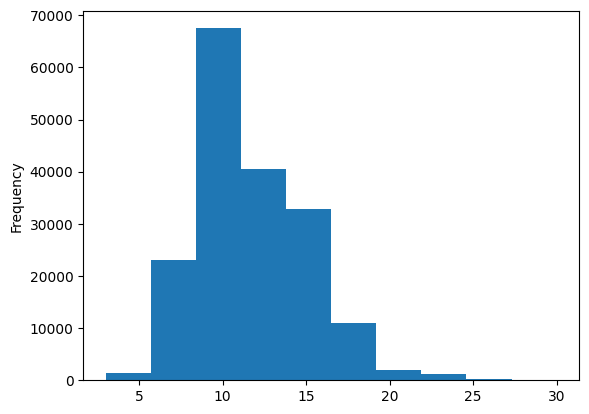

In [14]:
# Check for distribution of out abstract lengths
train_df.total_lines.plot.hist()

### Mendapatkan list dari kalimat (text)

Main inputs pada model machine learning kita akan mencari pola pada text yang sudah diembedding atau diberi token, sehingga kita perlu mengubah tipe data dari pandas.DataFrame menjadi list.

In [15]:
# Convert abstract text lines into list
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View frist 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Membuat numerical labels (Machine Learning models membutuhkan numerics labels)

Kita bisa saja hanya membuat encoded labels, namun, loss function seperti  CategoricalCrossentropy dari TensorFlow membutuhkan one hot encoded labels (ini akan memungkinkan kita untuk menggunakan perataan label di kemudian hari)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
# Extract labels convert one hot encoder into NumPy array
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting Baseline

Model pertama kita adalah TF-IDF Multinomial Naive Bayes seperti yang direkomendasikan oleh [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

Untuk membangunnya, kita akan membuat `Pipeline` Scikit-Learn yang menggunakan kelas [`TfidfVectorizer`] (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) untuk mengubah kalimat abstrak kita menjadi angka dengan menggunakan algoritma TF-IDF (term frequency-inverse document frequency) dan kemudian belajar untuk mengklasifikasikan kalimat-kalimat tersebut dengan menggunakan algoritma [`MultinomialNB`] (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

In [20]:
# Import important module
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions script

In [23]:
# Download helper Functions Scripts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-10 18:04:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-10 18:04:07 (86.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
model_0_result = calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
model_0_result

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [26]:
# Check all classes probs for our models
%%time
model_0_pred_classes = [label_encoder.classes_[pred] for pred in baseline_preds]
model_0_pred_classes

CPU times: user 7.14 ms, sys: 10 µs, total: 7.15 ms
Wall time: 7.21 ms


['RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'BACKGROUND',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESU

In [27]:
# Check all score probs for our models

model_0_preds_score = model_0.predict_proba(X=val_sentences)[:,1]
model_0_preds_score

array([0.19363321, 0.46871185, 0.17146895, ..., 0.00754448, 0.13085104,
       0.45950865])

In [28]:
# Data visualization using pandas DataFrame for clear output
import tensorflow as tf

# Create prediction train DataFrame
val_df["prediction"] = model_0_pred_classes
val_df["pred_prob"] = model_0_preds_score
val_df["correct"] = val_df["prediction"] == val_df["target"]
val_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9,RESULTS,0.193633,False
1,BACKGROUND,it is not clear whether these patients would b...,1,9,CONCLUSIONS,0.468712,False
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9,OBJECTIVE,0.171469,True
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9,METHODS,0.007133,True
4,METHODS,primary outcomes were improvement in quality o...,4,9,METHODS,0.047217,True
5,RESULTS,sixty-five patients were randomized .,5,9,METHODS,0.001820,False
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9,METHODS,0.002132,False
7,RESULTS,fifty-six patients took the full @ months of m...,7,9,METHODS,0.005096,False
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9,RESULTS,0.000565,True
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9,RESULTS,0.247397,False


### Melakukan testing model yang kita build dengan test datasets

In [29]:
# Predict test dataset using out NLP model_0
model_0_test_preds = model_0.predict(X=test_sentences)
model_0_test_preds

array([2, 2, 2, ..., 4, 4, 4])

In [30]:
# Calculate our model to test dataset results
model_0_test_result = calculate_results(y_true=test_labels_encoded , y_pred=model_0_test_preds)
model_0_test_result

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

In [31]:
# Check all classes probs for our models on test dataset
%%time
model_0_pred__test_classes = [label_encoder.classes_[pred] for pred in model_0_test_preds]
model_0_pred__test_classes

CPU times: user 5.31 ms, sys: 27 µs, total: 5.34 ms
Wall time: 5.7 ms


['METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',

In [32]:
# Check all score probs for our models on test datasets

model_0_preds_test_score = model_0.predict_proba(X=test_sentences)[:,1]
model_0_preds_test_score

array([0.12749629, 0.06260306, 0.00620673, ..., 0.01099989, 0.04184932,
       0.27318945])

In [33]:
# Create prediction test DataFrame
test_df["prediction"] = model_0_pred__test_classes
test_df["pred_prob"] = model_0_preds_test_score
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,METHODS,0.127496,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.062603,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.006207,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,RESULTS,0.009223,True
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.012227,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.007419,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.001235,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.375460,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.258711,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.310171,True


In [34]:
test_wrong_preds = test_df[test_df["correct"] == False][0:]
test_wrong_preds

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,METHODS,0.127496,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.062603,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.006207,False
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.258711,False
10,BACKGROUND,the aim of this study was to analyse the cost-...,1,12,METHODS,0.125255,False
...,...,...,...,...,...,...,...
30116,CONCLUSIONS,a @-drug daily regimen with moxifloxacin resul...,9,9,METHODS,0.105207,False
30118,OBJECTIVE,to compare the effectiveness of the alfredson ...,1,17,BACKGROUND,0.245324,False
30119,BACKGROUND,the alfredson protocol recommends the completi...,2,17,METHODS,0.123464,False
30120,BACKGROUND,"however , completing this large number of repe...",3,17,CONCLUSIONS,0.309404,False


In [35]:
len(test_wrong_preds), len(model_0_test_preds)

(8538, 30135)

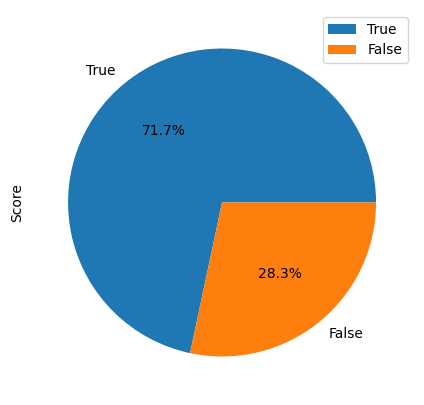

In [36]:
test_pie_chart = pd.DataFrame({"Score":[(len(model_0_test_preds)-len(test_wrong_preds)), len(test_wrong_preds)]},
                              index=['True', 'False'])
model_0_test_plot = test_pie_chart.plot.pie(y='Score', figsize=(5, 5),
                   autopct='%1.1f%%')

## Menyiapkan data kita untuk model deep sequence

Sebelum kita mulai membangun deeper model, kita harus membuat vectorization dan embedding layers.

Vectorization layer akan mengubah teks kita menjadi angka dan embedding layer akan menangkap pola / relasi antara angka-angka tersebut.

Untuk memulai membuat vectorization dan embedding layers kita perlu mengimport beberapa library yang sesuai (yaitu TensorFlow dan NumPy.


In [37]:
# Import some library for preparing data
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [38]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

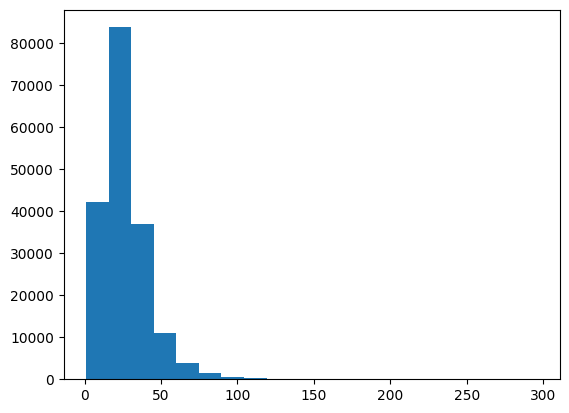

In [39]:
# Check the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [40]:
# How long of a sentences lenght covers 95% of examples?
output_seq = int(np.percentile(sent_lens, 95))
output_seq

55

In [41]:
# Maximum sentence length in the training set
max(sent_lens)

296

##Membuat text vectorizer

Untuk melakukannya kita akan menggunakan [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

Semua parameter akan tetap default kecuali `max_tokens` (jumlah unique word dalam dataset kami) dan `output_sequence_length` (panjang keluaran yang diinginkan untuk setiap kalimat vector)

Pada jurnal [PubMed 20k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) menyatakan ukuran kosakata dataset PubMed 20k adalah 68.000. Jadi kita akan menggunakannya sebagai parameter `max_tokens`.

In [42]:
# Token or word in our vocabulary
max_tokens = 68000

In [43]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=55,
)

In [44]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [45]:
# Test out text vectorizer
import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence)}")
print(f"\nVectorized Text:{text_vectorizer([target_sentence])}")

Text:
children with the late-onset p.n@s mutation had normal urinary levels of gb@ , and lyso-gb@ but abnormal levels of related analogues .

Length of text:134

Vectorized Text:[[  109     7     2 12573  7643  2321    55   417   616    93     4  3138
      3 25863    72  1528    93     4   328  6844     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [46]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [47]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [48]:
# Create token embedding
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="Token_Embedding"
                               )

# Show example embbeding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding ):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 children with the late-onset p.n@s mutation had normal urinary levels of gb@ , and lyso-gb@ but abnormal levels of related analogues .
Sentence after vectorization (before embedding ):
 [[  109     7     2 12573  7643  2321    55   417   616    93     4  3138
      3 25863    72  1528    93     4   328  6844     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01204789  0.00610565  0.01561793 ... -0.02046489  0.00051758
    0.01624551]
  [-0.03022289  0.02063182  0.03028966 ...  0.04497169 -0.00359681
    0.04594246]
  [-0.02638391  0.01898536 -0.02712359 ... -0.04512737  0.03841598
    0.01081728]
  ...
  [-0.00929534 -0.02564777 -0.00451615 ...  0.00411729 -0.03601053
   -0.04271277]
  [-0.00929534 -0.02564777 -0.00451615 ...  0.00411729 -0.03601053
   -0.04

### Membuat dataset menjadi TensorFlow format data

In [49]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [50]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Seluruh model machine learning akan mengikuti struktur yang hampir mirip yaitu :

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Model yang akan kita buat nantinya adalah 1-dimensional Convolutional Neural Network.

Algoritma yang akan dikerjakaan pada standart machine learning ini adalah:
- Build model
- Train model
- Evaluate model (make predictions and compare to ground truth)

In [51]:
# Create 1D CNN model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 Token_Embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [53]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 31s 38ms/step - loss: 0.9116 - accuracy: 0.6406 - val_loss: 0.6806 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6562 - accuracy: 0.7585 - val_loss: 0.6316 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6165 - accuracy: 0.7735 - val_loss: 0.5955 - val_accuracy: 0.7852


In [54]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5981 - accuracy: 0.7871


[0.598082423210144, 0.7871375679969788]

In [55]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.4252723e-01, 1.8437637e-01, 6.5096721e-02, 2.8617063e-01,
        2.1829173e-02],
       [4.2378694e-01, 3.0456522e-01, 1.3606999e-02, 2.4866825e-01,
        9.3725026e-03],
       [1.3187595e-01, 5.7983939e-03, 1.5670527e-03, 8.6073774e-01,
        2.0830348e-05],
       ...,
       [7.1213613e-06, 8.4470335e-04, 6.0788397e-04, 2.4584683e-06,
        9.9853778e-01],
       [4.2143974e-02, 4.3853068e-01, 9.8340526e-02, 4.9587745e-02,
        3.7139708e-01],
       [1.7442670e-01, 6.8202829e-01, 3.7102383e-02, 4.6951599e-02,
        5.9490979e-02]], dtype=float32)

In [56]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [57]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.71375612339467,
 'precision': 0.7841107368480704,
 'recall': 0.7871375612339467,
 'f1': 0.7845230999339307}

In [58]:
%%time
# Get list of class names of val_pred
model_pred_classes = [label_encoder.classes_[pred] for pred in model_1_preds]
model_pred_classes

CPU times: user 13.4 s, sys: 831 ms, total: 14.3 s
Wall time: 13.6 s


['BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'BACKGROUND',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RES

In [59]:
# Create prediction val dataframe
val_df["prediction"] = model_pred_classes
val_df["pred_prob"] = tf.reduce_max(model_1_pred_probs, axis=1).numpy() # get the maximum prediction probability
val_df["correct"] = val_df["prediction"] == val_df["target"] # create binary column for whether the prediction is right or not
val_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9,BACKGROUND,0.442527,True
1,BACKGROUND,it is not clear whether these patients would b...,1,9,BACKGROUND,0.423787,True
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9,OBJECTIVE,0.860738,True
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9,METHODS,0.979059,True
4,METHODS,primary outcomes were improvement in quality o...,4,9,RESULTS,0.648590,False
5,RESULTS,sixty-five patients were randomized .,5,9,METHODS,0.574332,False
6,RESULTS,fifty-nine patients started treatment ( @ rece...,6,9,RESULTS,0.726743,True
7,RESULTS,fifty-six patients took the full @ months of m...,7,9,METHODS,0.659698,False
8,RESULTS,"between the voriconazole and placebo groups , ...",8,9,RESULTS,1.000000,True
9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9,9,CONCLUSIONS,0.748216,True
